# Exploratory Data Analysis

## Weather

The weather data has not datetime as the other data sets, so it will be created first from the year/month/day/time columns. Then specifying datetime sa index.

In [2]:
import pandas as pd
import numpy as np

weather = pd.read_csv('weather_kumpula_012019-092022.csv')
weather = weather.rename(columns={'Vuosi': 'year', 'Kk':'month', 'Pv': 'day', 'Klo':'time'})
weather['hour'] = weather['time'].apply(lambda time: int(time[0:2]))
weather['datetime'] = pd.to_datetime(weather[['year','month','day','hour']])
weather = weather.set_index('datetime')

In [5]:
weather.tail()

,year,month,day,time,Aikavyöhyke,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Sademäärä (mm),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Ilman lämpötila (degC),Tuulen nopeus (m/s),hour
datetime,,,,,,,,,,,,,
2021-03-29 20:00:00,2021,3,29,20:00,UTC,7.0,1012.1,0.9,99.0,0.7,4.0,7.0,20
2021-03-29 21:00:00,2021,3,29,21:00,UTC,7.0,1011.7,0.6,99.0,0.4,3.7,8.8,21
2021-03-29 22:00:00,2021,3,29,22:00,UTC,7.0,1011.0,0.3,99.0,0.2,3.8,7.9,22
2021-03-29 23:00:00,2021,3,29,23:00,UTC,7.0,1011.0,0.4,99.0,0.5,4.0,7.9,23
2021-03-30 00:00:00,2021,3,30,00:00,UTC,7.0,1011.1,0.1,99.0,0.0,3.8,7.6,0


Then replacing the empty values, expressed as '-' to np.nan. Then changing the types of columns to float. (Integer does not work with np.nan)

In [6]:
weather = weather.replace('-',np.nan)
coltypes = {'Pilvien määrä (1/8)':np.float64, 
            'Ilmanpaine (msl) (hPa)': np.float64,
            'Sademäärä (mm)' : np.float64,
            'Suhteellinen kosteus (%)': np.float64,
            'Sateen intensiteetti (mm/h)':np.float64,
            'Ilman lämpötila (degC)':np.float64,
            'Tuulen nopeus (m/s)':np.float64}

weather = weather.astype(coltypes)

In [7]:
weather.dtypes

year                             int64
month                            int64
day                              int64
time                            object
Aikavyöhyke                     object
Pilvien määrä (1/8)            float64
Ilmanpaine (msl) (hPa)         float64
Sademäärä (mm)                 float64
Suhteellinen kosteus (%)       float64
Sateen intensiteetti (mm/h)    float64
Ilman lämpötila (degC)         float64
Tuulen nopeus (m/s)            float64
hour                             int64
dtype: object

<AxesSubplot:title={'center':'Temperature'}, xlabel='datetime'>

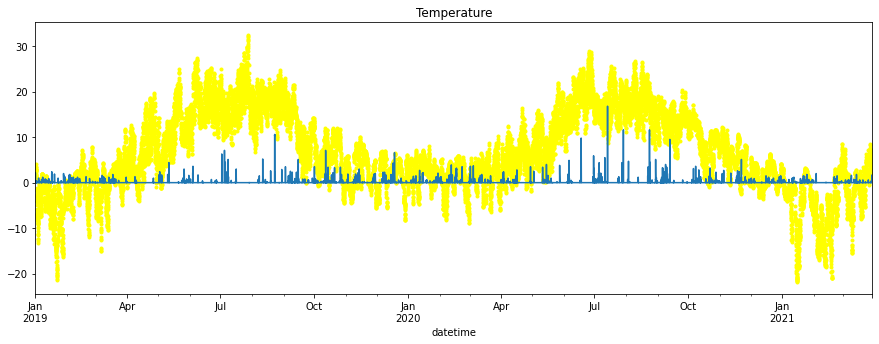

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

weather.loc[:,'Ilman lämpötila (degC)'].plot(ax=ax, style='.', color='yellow', figsize=(15,5), title='Temperature')
weather.loc[:,'Sademäärä (mm)'].plot(ax=ax, style='-', figsize=(15,5), title='Temperature')